In [1]:
#import the packages here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import emcee
import math
import george
from george import kernels
from pylab import *
import corner

In [2]:
#load data and model here
spectra = pd.read_csv('/home/ade/Documents/Research/comparemodel/model_spectra_all_200.csv')

In [3]:
#start of wavelength range
print(str(spectra.w_obj[min(range(len(spectra.w_obj)), key=lambda i: abs(spectra.w_obj[i]-5770.))]))
print(min(range(len(spectra.w_obj)), key=lambda i: abs(spectra.w_obj[i]-5770.)))

nearest_index_max_start_wav = min(range(len(spectra.w_obj)), key=lambda i: abs(spectra.w_obj[i]-5770))
if spectra.w_obj[nearest_index_max_start_wav] < 5770.:
    nearest_index_max_start_wav = nearest_index_max_start_wav + 1
print(spectra.w_obj[nearest_index_max_start_wav])
print(nearest_index_max_start_wav)

5770.00062666094
2023
5770.00062666094
2023


In [4]:
#end of wavelength range
print(str(spectra.w_obj[min(range(len(spectra.w_obj)), key=lambda i: abs(spectra.w_obj[i]-5790.))]))
print(min(range(len(spectra.w_obj)), key=lambda i: abs(spectra.w_obj[i]-5790.)))

nearest_index_min_end_wav = min(range(len(spectra.w_obj)), key=lambda i: abs(spectra.w_obj[i]-5790.))
if spectra.w_obj[nearest_index_min_end_wav] > 5790.:
    nearest_index_min_end_wav = nearest_index_min_end_wav - 1
print(spectra.w_obj[nearest_index_min_end_wav])
print(nearest_index_min_end_wav)

5790.018121023037
2389
5789.96342841549
2388


In [5]:
#the spectra
spectra = spectra.iloc[nearest_index_max_start_wav: nearest_index_min_end_wav]

In [6]:
#propagation of uncertainty to acquire error of f_obj/f_mean
def y_error(y_obj, e_obj, y_mod, e_mod):
    return (e_obj/y_obj)+(e_mod/y_mod) * (y_obj/y_mod)

#yerr = y_error(spectra.f_obj, spectra.e_obj, spectra.f_mean, spectra.f_stddev)
yerr = spectra.e_obj

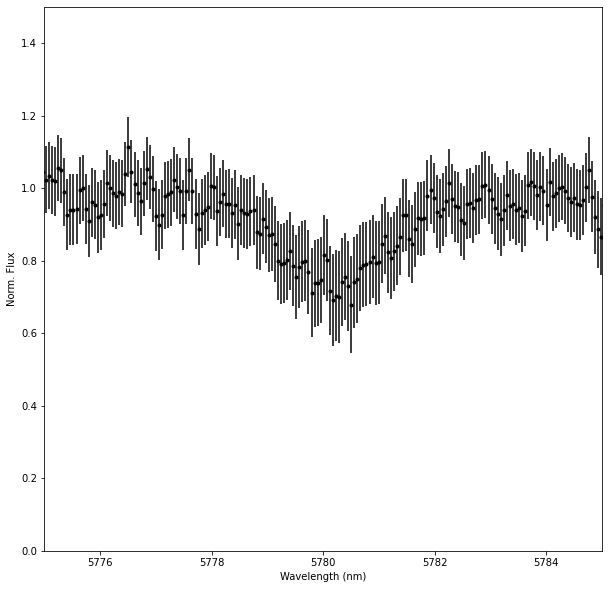

In [7]:
plt.figure(figsize = (10,10))
plt.errorbar(spectra.w_obj,spectra.f_obj/spectra.f_mean, yerr = yerr, fmt = 'k.', capsize=0)
#plt.scatter(spectra.w_obj,spectra.f_obj/spectra.f_mean)
plt.xlim(5775, 5785)
plt.ylim(0, 1.5)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Norm. Flux")
plt.show()

In [24]:
#collection of function: prior and likelihood
#def model(w, A, sigma, mu): #w = wavelength
#    return (1-(A/(2*np.pi*(sigma**2))**0.5) * (np.exp(-np.power(w - mu, 2.) / (2 * np.power(sigma, 2.)))))

def model(p,x):
    a,s,m=p
    #return 1-((a/(2*np.pi*(s**2))**0.5) * exp(-(x-m)**2/(2*s**2)))
    return (1-(a/(2*np.pi*(s**2))**0.5) * (np.exp(-np.power(x - m, 2.) / (2 * np.power(s, 2.)))))
    #return 1-a * exp(-(x-m)**2/(2*s**2)
                     

def log_likelihood(theta, w, difference, error): #difference = f_obj/f_mean, error = error propagation of f_obj/f_mean
    A, sigma, mu = theta
    model = (1-(A/(2*np.pi*(sigma**2))**0.5) * (np.exp(-np.power(w - mu, 2.) / (2 * np.power(sigma, 2.)))))
    return -0.5*np.sum((difference-model)**2/error**2) #+ np.log((A/(2*np.pi*(sigma**2))**0.5))

def log_prior(theta):
    A, sigma, mu = theta
    
    #if 0 < A < 5 and 0.01 < sigma < 5.5 and (5780.5 - 3) < mu < (5780.5 + 3):
    #    return 0.0
    #return -np.inf
    
    lnp=0.0
    
    #Flat prior on A
    if 0 <= A <= 1:
        lnp-=0.0
    #elif 0.2 < A <= 0.4:
    #    lnp+=np.log(np.log(-5 * A + 2))
    else :
        return -np.inf
    
    
    #Skewed Gaussian prior on sigma
    m_sigma = 0.2
    s_sigma = 0.5
    gamma = 2
    
    if 0.00 < sigma < 1.5:
        lnp += np.log(1./(np.sqrt(2*np.pi*(s_sigma**2)))) + (-0.5*(sigma-m_sigma)**2/s_sigma**2) + np.log(1 + math.erf((gamma*(sigma-m_sigma))/s_sigma*(2**0.5)))
    else :
        return -np.inf
    
    
    #Gaussian prior on mu
    m_mu = i_mu
    s_mu = 1.

    if 5778 < mu < 5782:
        lnp += np.log(1.0/(np.sqrt(2*np.pi)*s_mu))-(0.5*(mu-m_mu)**2/s_mu**2)
    else :
        return -np.inf

    return lnp


def log_probability(theta, w, difference, error):
    lp = log_prior(theta)
    #print (lp)
    if not np.isfinite(lp):
        return -np.inf

    return lp + log_likelihood(theta, w, difference, error)

In [25]:
#distribution of walkers
i_A, i_sigma, i_mu = 0.6, 1.0, 5780 #initial A, sigma, mu. Or simply the mean
i_b, i_a, i_c = 0.05, 0.05, 2 #the spread, or mu of Gaussian distribution
pos_A = np.random.normal(i_A, i_b, 100)
pos_sigma = np.random.normal(i_sigma, i_a, 100)
pos_mu = np.random.normal(i_mu, i_c, 100)

In [26]:
gp=george.GP(5*np.var(spectra.f_obj)*kernels.Matern32Kernel(1.05), mean=0)
gp.compute(spectra.w_obj, yerr)

In [11]:
pos = np.array([pos_A, pos_sigma, pos_mu]).T #transpose the array of A, sigma, and mu

In [12]:
nwalkers, ndim = pos.shape

In [27]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(spectra.w_obj, spectra.f_obj/spectra.f_mean, yerr), threads = 8)
position, _ , _ = sampler.run_mcmc(pos, 500, progress=True);

  0%|          | 0/500 [00:00<?, ?it/s]/home/ade/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [01:36<00:00,  5.20it/s]


In [28]:
flat_samples = sampler.get_chain(discard = 0, flat=True)[sampler.flatlnprobability>np.percentile(sampler.flatlnprobability,20)]

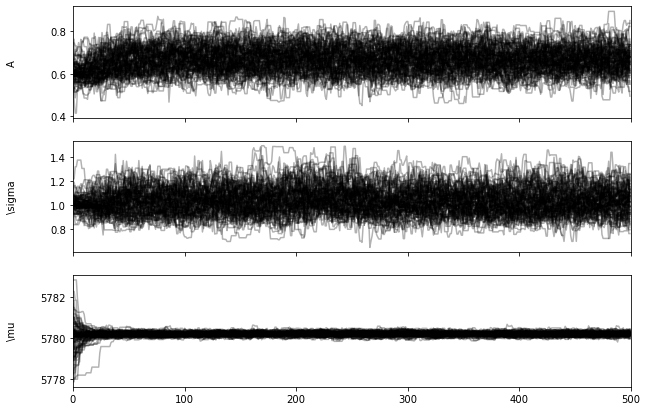

In [29]:
labels = [r"A", r"\sigma", r"\mu"]

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for j in range(ndim):
    ax = axes[j]
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

In [30]:
s=[np.median(samples[:,0]), np.median(samples[:,1]), np.median(samples[:,2])]

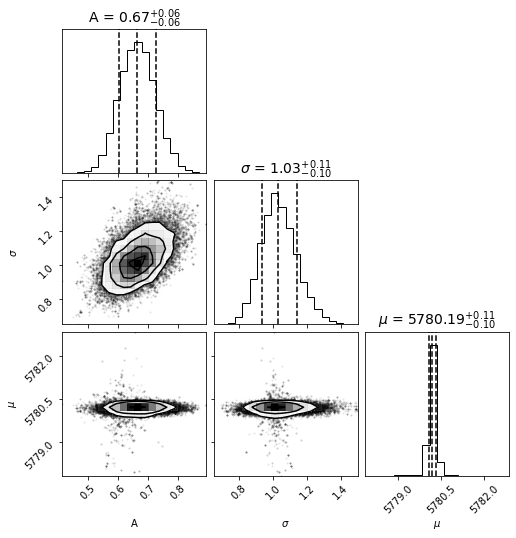

In [31]:
labels = ["A", r"$\sigma$", r"$\mu$"]
names = gp.get_parameter_names()
inds = [0, 1, 2]
corner.corner(sampler.flatchain[:, inds], labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 14});

In [32]:
xx=np.linspace(5770,5790,1000)
s=[np.median(flat_samples[:,0]), np.median(flat_samples[:,1]), np.median(flat_samples[:,2])]

m = gp.sample_conditional(spectra.f_obj/spectra.f_mean - model(s, spectra.w_obj), xx) + model(s, xx) #correlated noise + model
mm = model(s, xx) #model only
mu = gp.sample_conditional(spectra.f_obj/spectra.f_mean - model(s, spectra.w_obj), xx)

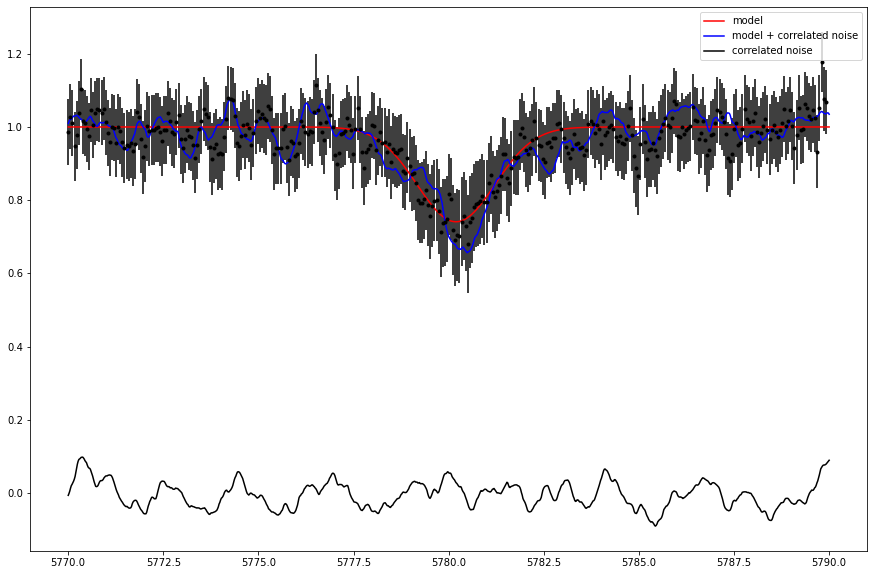

In [33]:
figure(1, figsize = (15,10))
errorbar(spectra.w_obj, spectra.f_obj/spectra.f_mean, yerr=yerr, fmt=".k", capsize=0)
plot(xx,mm,'r-', label = 'model')
plot(xx,m,'b-', label = 'model + correlated noise')
plot(xx,mu,'k-', label = 'correlated noise')
legend()

In [34]:
samples = sampler.get_chain(discard = 0, flat=True)[sampler.flatlnprobability>np.percentile(sampler.flatlnprobability,20)]

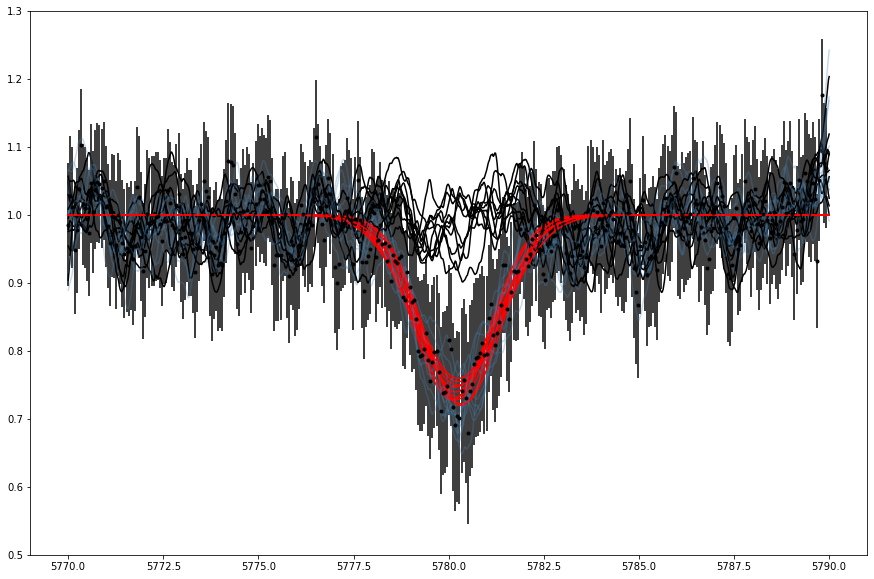

In [40]:
figure(1, figsize = (15,10))
errorbar(spectra.w_obj, spectra.f_obj/spectra.f_mean, yerr=yerr, fmt=".k", capsize=0)
ylim(0.5, 1.3)

for s in samples[np.random.randint(len(samples), size=10)]:
    #gp.set_parameter_vector(s)
    #print(s)
    
    mu = gp.sample_conditional(spectra.f_obj/spectra.f_mean - model_test(s, spectra.w_obj), xx) + model_test(s, xx)
    #mu = gp.sample_conditional(spectra.f_obj/spectra.f_mean - model(spectra.w_obj, s[s][0], s[s][1], s[s][2]), xx) + model(xx, s[s][0], s[s][1], s[s][2])
    #mu_val.append(mu)
    m = gp.sample_conditional(spectra.f_obj/spectra.f_mean - model(s, spectra.w_obj), xx) + 1
    mm = model(s, xx)
    plot(xx,mm,'r-', label = 'model')
    plot(xx,m,'k-', label = 'correlated noise')
    plt.plot(xx, mu, color="#4682b4", alpha=0.3)